## Fast Plot
### Alexandra Higley

A program to pick out parameters from .par files in a directory, then plot them against a change in obervatory position (specifically gbt as of right now). The par files were made using my other programs, mobsfun.py and loop.py through the Slurm Workload Manager on bowser. The original par files were taken from nanograv working.par files off the nanograv shared notebook. 

The purpose of this program is to see how the contents of the parameter files change as the observatory coordinates change. Here, we are chaging them by some positive increment in all directions (x, y, and z). 

In [1]:
import numpy as np
from pylab import *
from math import e
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from astropy import units as u
from astropy.coordinates import SkyCoord
#from scipy.optimize import curve_fit
#from astropy.io import fits
import glob
#import os

import astroquery
from astropy.io import fits
from astropy.wcs import WCS
from astroquery.skyview import SkyView
import matplotlib.pyplot as plt
import urllib

You can't easily specify single rows using loadtxt, so the following function does that— calls a specific row from a text file. 

In [2]:
# credit this function to Mokhtar Ebrahim, April 21, 2020
# https://likege3eks.com/numpy-loadtxt-tutorial/
def generate_specific_rows(filePath, row_indices=[]):
    with open(filePath) as f:
        # using enumerate to track line no.
        for i, line in enumerate(f):
            #if line no. is in the row index list, then return that line
            if i in row_indices:
                yield line

We now need to load all the desired parameter files for a desired pulsar. Note that par_list can be changed depending on what pulsar you want to look at, or if the path changes from user to user. They are then sorted numerically (01 to 13)

In [3]:
#using glob.glob to all all par-like files 

#par_list = glob.glob('/Users/alexh/Desktop/Coding/Pulsars/s*.par')
#par_list = glob.glob('/Users/alexh/Desktop/Coding/Pulsars/J1713+0747/J1713+0747*.par')
#par_list = glob.glob('/Users/alexh/Desktop/Coding/Pulsars/J0340+4130/J0340+4130*.par')
par_list = glob.glob('/Users/alexh/Desktop/Coding/Pulsars/J0610-2100/J0610-2100*.par')

par_list = np.sort(par_list,kind='standardsort')

We need to find where each desired row is since it slightly changes from par file to par file. This can be done using np.where and searching for the name of the desired parameter. It should be noted that this will only work for files with ecliptic longitude and latitude coordinates. There is a handful of pulsars that instead us RA/DEC and those pulsars will crash fastplot— a work-around is being addressed but for now, avoid the following pulsars:

In [4]:
namt=loadtxt(par_list[0], skiprows=0,unpack=True,usecols=(0),dtype='str')
#loading first (01) par file in its entirety 

#Finding where (which row) each parameter is 
elongt = np.where(namt=="ELONG")
elatt = np.where(namt=="ELAT")
f0t = np.where(namt=="F0")
f1t = np.where(namt=="F1")
trest = np.where(namt=="TRES")
pxt = np.where(namt=="PX")
pmelongt = np.where(namt=="PMELONG")
pmelatt = np.where(namt=="PMELAT")

#I also wanted to easily call the name of the pulsar for plotting. The name (PSRJ) will always be the first line (0) 
# so I didn't use np.where but I could have. I have it as a string. 
namr=loadtxt(par_list[0], skiprows=0,unpack=True,usecols=(1),dtype='str')
name = namr[0]

With all the row numbers realized, the data can now be found from the par files and put into arrays. To do so, I have these four functions. getdat calls elong, elat, f0, f1, and tres. geterr calls the error associated with elong, elat, f0 and f1. 

Parallax and propoer motion wanted to be added in after-the-fact, but for whatever reason I couldn't just add them in the original getdat and geterr functions. I trouble shooted it for a while but decided it was less effort to just make superate funtions for them. So, getmoredat calls px, pmelong and pmelat. getmoreerr calls their corresponding error. 

In [5]:
def getdat(num):
    #gen1 = generate_specific_rows(par_list[num],row_indices = [elongt[0], elatt[0], f0t[0], f1t[0], trest[0]])
    gen1 = generate_specific_rows(par_list[num],row_indices = [1,2,3,4, trest[0]])
    dat=loadtxt(gen1, skiprows=0,unpack=True,usecols=(1))
    
    return dat

def geterr(num):
    gen2 = generate_specific_rows(par_list[num],row_indices = [elongt[0], elatt[0], f0t[0], f1t[0]])
    err1=np.loadtxt(gen2,usecols=(3))
    
    return err1

def getmordat(num):
    gen3 = generate_specific_rows(par_list[num],row_indices = [pxt[0], pmelongt[0], pmelatt[0]])
    mdat=loadtxt(gen3, skiprows=0,unpack=True,usecols=(1))
    
    return mdat


def getmorerr(num):
    gen4 = generate_specific_rows(par_list[num],row_indices = [pxt[0], pmelongt[0], pmelatt[0]])
    err2=np.loadtxt(gen4,usecols=(3))
    
    return err2

In [6]:
#Initializing for data
ELONG = np.empty(len(par_list))
ELAT  = np.empty(len(par_list))
F0 = np.empty(len(par_list))
F1 = np.empty(len(par_list))
TRES = np.empty(len(par_list))
PMELONG = np.empty(len(par_list))
PMELAT = np.empty(len(par_list))
PX = np.empty(len(par_list))

#Filling arrays for data
for i in range(0,len(par_list)):
    ELONG[i] = getdat(i)[0]
    ELAT[i] = getdat(i)[1]
    F0[i] = getdat(i)[2]
    F1[i] = getdat(i)[3]
    TRES[i] = getdat(i)[4]
    PMELONG[i] = getmordat(i)[0]
    PMELAT[i] = getmordat(i)[1]
    PX[i] = getmordat(i)[2]
    
    
#Initializing for error
ELONGe = np.empty(len(par_list))
ELATe = np.empty(len(par_list))
F0e = np.empty(len(par_list))
F1e = np.empty(len(par_list))
PMELONGe = np.empty(len(par_list))
PMELATe = np.empty(len(par_list))
PXe = np.empty(len(par_list))

#Filling arrays for error
for i in range(0,len(par_list)):
    ELONGe[i] = geterr(i)[0]
    ELATe[i] = geterr(i)[1]
    F0e[i] = geterr(i)[2]
    F1e[i] = geterr(i)[3]
    PMELONGe[i] = getmorerr(i)[0]
    PMELATe[i] = getmorerr(i)[1]
    PXe[i] = getmorerr(i)[2]
    
print(PMELONGe)

[0.33385772 0.33385723 0.3338538  0.33382062 0.33359416 0.33357129
 0.33494546 0.33845804 0.34195699 0.37213297 0.54733583 0.77803793
 0.94316552]


Now we can finally plot. dx is representitive of how many meters the observatory was moved. For now, the observatory was moved all in the positive x,y.and z firection the same amount. 

In [7]:
dx = np.array([0, 1, 10, 100, 1000, 2000, 5000, 8000, 10000, 20000, 50000, 80000, 100000])
test = (np.arange(0,15))

print(TRES)

[ 5.26   5.26   5.26   5.26   5.256  5.256  5.277  5.333  5.388  5.863
  8.624 12.258 14.86 ]


## RMS Plot

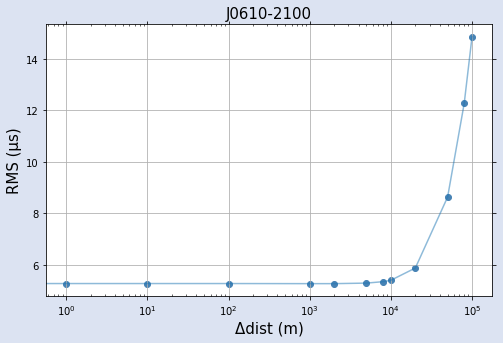

In [8]:
fig2,ax2 =plt.subplots(figsize=(8,5))
fig2.patch.set_facecolor('#DCE3F2')

#ax2.plot(dx, TRES,alpha=0.5)
#ax2.scatter(dx, TRES,color='steelblue')

ax2.plot(dx, TRES,alpha=0.5)
ax2.scatter(dx, TRES,color='steelblue')

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('RMS (μs)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)
ax2.grid()

ax2.set_title(name,fontsize = 15)

#plt.savefig(name)
plt.show()

In [9]:
#differences between 0dx change and others 
new1 = (ELONG - ELONG[0])
new2 = (ELAT - ELAT[0])

#error
new1e = (ELONGe - ELONGe[0])
new2e = (ELATe - ELATe[0])

## ELONG and ELAT Plots

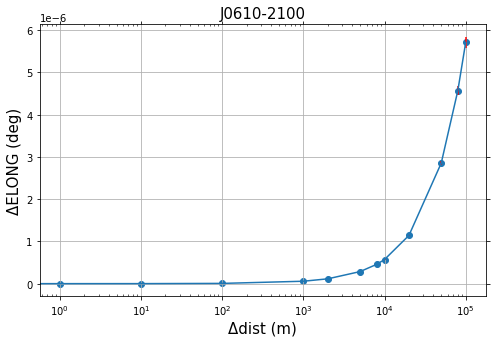

In [10]:
fig2,ax2 =plt.subplots(figsize=(8,5))

ax2.plot(dx, new1)
ax2.scatter(dx, new1)
ax2.errorbar(dx, new1, new1e, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('ΔELONG (deg)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)
ax2.grid()

ax2.set_title(name,fontsize = 15)

plt.show()

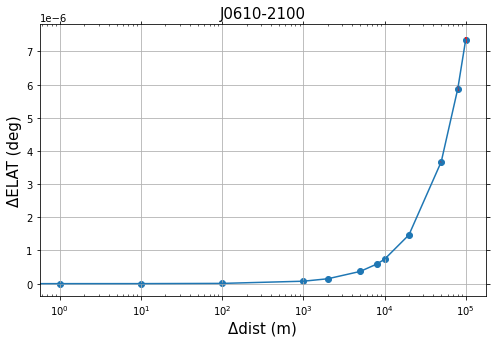

In [11]:
fig2,ax2 =plt.subplots(figsize=(8,5))

ax2.plot(dx, new2)
ax2.scatter(dx, new2)
ax2.errorbar(dx, new2, new2e, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('ΔELAT (deg)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)
ax2.grid()

ax2.set_title(name,fontsize = 15)

plt.show()

## RA and DEC Plots 

For RA and DEC, we need to convert from barycentric elcliptic coordinates to icrs. To do this I used astropy. Note that I'm not 100% sure this is working exactly correct because some of them have a very large RA that appears off the sky plot. I still need to correct for that. The ones that I took note of with this problem are listed below, but I might have missed a few because I wasn't aware of the issue until I was halfway through 

In [12]:
place = SkyCoord(ELONG[0:]*u.deg, ELAT[0:]*u.deg, frame='barycentrictrueecliptic') #latitude & longitude
placee = SkyCoord(ELONGe[0:]*u.deg, ELATe[0:]*u.deg, frame='barycentrictrueecliptic') #latitude & longitude error

from astropy.coordinates import ICRS
cop = place.transform_to('icrs') #RA and DEC 
cope = placee.transform_to('icrs') #RA and DEC error

In [13]:
#radians
ra_rad = cop.ra.wrap_at(180 * u.deg).radian
dec_rad = cop.dec.radian

ra_rade = cope.ra.wrap_at(180 * u.deg).radian #error
dec_rade = cope.dec.radian


#differences between 0dx change and others 
diffra_rad = (ra_rad - ra_rad[0])
diffdec_rad = (dec_rad - dec_rad[0])

diffra_rade = (ra_rade - ra_rade[0]) #error
diffdec_rade = (dec_rade - dec_rade[0])

In [14]:
#degrees
ra_deg = cop.ra.degree
dec_deg = cop.dec.degree

ra_dege = cope.ra.degree #error
dec_dege = cope.dec.degree


#differences between 0dx change and others 
diffra_deg = (ra_deg - ra_deg[0])
diffdec_deg = (dec_deg - dec_deg[0])

diffra_dege = (ra_dege - ra_dege[0]) #error
diffdec_dege = (dec_dege - dec_dege[0])

In [15]:
colors = cm.rainbow(np.linspace(0, 1, len(dx))) #rainbow color map. Might change it to something colorblind friendly 

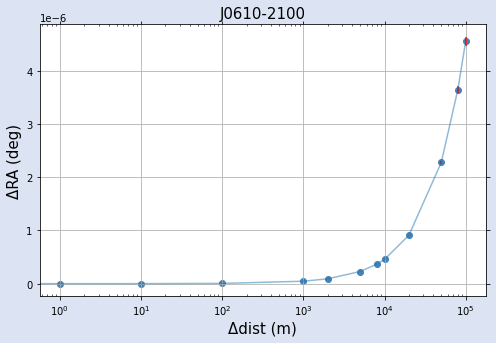

In [16]:
fig2,ax2 =plt.subplots(figsize=(8,5))
fig2.patch.set_facecolor('#DCE3F2')

ax2.scatter(dx,diffra_deg,color='steelblue')
ax2.plot(dx,diffra_deg,alpha=0.5)
ax2.errorbar(dx, diffra_deg, diffra_dege, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('ΔRA (deg)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)

ax2.set_title(name,fontsize = 15)
ax2.grid()

plt.show()

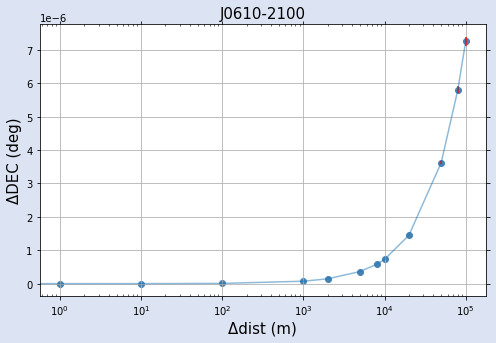

In [17]:
fig2,ax2 =plt.subplots(figsize=(8,5))
fig2.patch.set_facecolor('#DCE3F2')

ax2.scatter(dx,diffdec_deg,color='steelblue')
ax2.plot(dx,diffdec_deg,alpha=0.5)
ax2.errorbar(dx, diffdec_deg, diffdec_dege, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('ΔDEC (deg)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)

ax2.set_title(name,fontsize = 15)
ax2.grid()

plt.show()

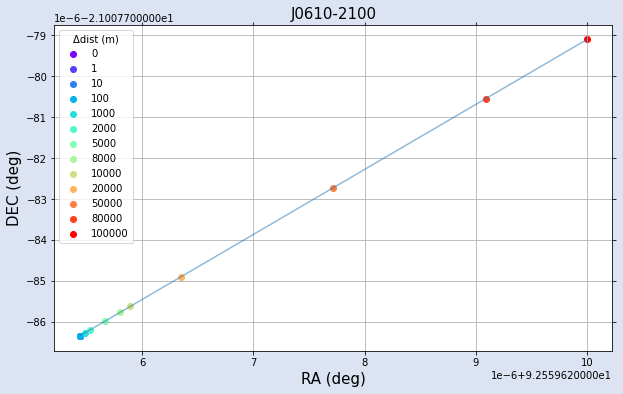

In [18]:
fig2,ax2 =plt.subplots(figsize=(10,6))
fig2.patch.set_facecolor('#DCE3F2')

for i in range(len(ra_deg)):
    ax2.scatter(ra_deg[i], dec_deg[i], label=dx[i], color=colors[i])

ax2.plot(ra_deg,dec_deg,alpha=0.5)

ax2.set_xlabel('RA (deg)',fontsize=15)
ax2.set_ylabel('DEC (deg)',fontsize=15)


ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)

ax2.set_title(name,fontsize = 15)

plt.legend(title="Δdist (m)")
ax2.grid()
plt.show()

## Parallax Plot

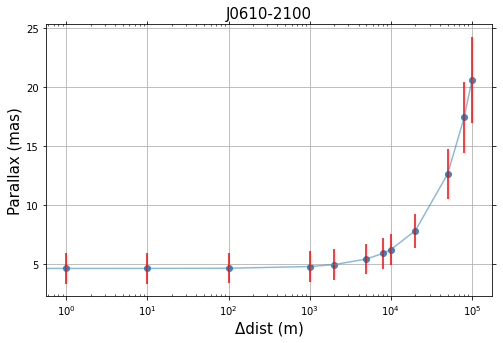

In [19]:
fig2,ax2 =plt.subplots(figsize=(8,5))

ax2.plot(dx, PX,alpha=0.5)
ax2.scatter(dx, PX,color='steelblue')
ax2.errorbar(dx, PX, PXe, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('Parallax (mas)',fontsize=15) #we think it's milliarcseconds, could be something else 
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)
ax2.grid()

ax2.set_title(name,fontsize = 15)

#plt.savefig(name)
plt.show()


## Proper Motion Plots

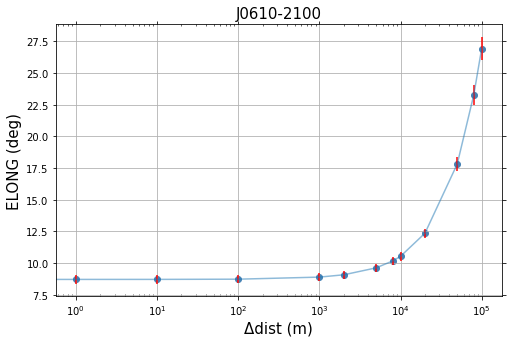

In [20]:
fig2,ax2 =plt.subplots(figsize=(8,5))

ax2.plot(dx, PMELONG,alpha=0.5)
ax2.scatter(dx, PMELONG,color='steelblue')
ax2.errorbar(dx, PMELONG, PMELONGe, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('ELONG (deg)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)
ax2.grid()

ax2.set_title(name,fontsize = 15)

#plt.savefig(name)
plt.show()

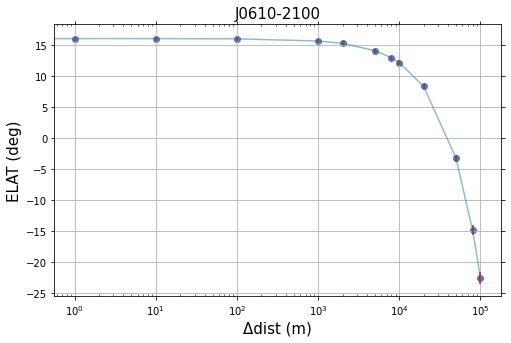

In [21]:
fig2,ax2 =plt.subplots(figsize=(8,5))

ax2.plot(dx, PMELAT,alpha=0.5)
ax2.scatter(dx, PMELAT,color='steelblue')
ax2.errorbar(dx, PMELAT, PMELATe, linestyle='None', color="red")

ax2.set_xlabel('Δdist (m)',fontsize=15)
ax2.set_ylabel('ELAT (deg)',fontsize=15)
plt.xscale('log')

ax2.tick_params(axis='both',which='minor',direction='in')
ax2.tick_params(top=True,right=True)
ax2.tick_params(which='minor',top=True,right=True)
ax2.grid()

ax2.set_title(name,fontsize = 15)

#plt.savefig(name)
plt.show()

## Sky Plot

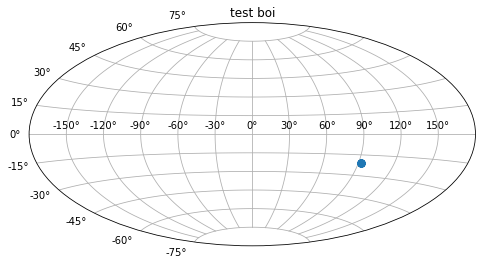

In [22]:
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.title("test boi")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=7)
#ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

Later, I think it would be cool to have a sky plot with all the pulsars on it and with the wonky ones tagged in a different color to see if there is any correlation between place in sky and weirdness. The weird ones that I know of are the following:

In [23]:
#J0605+3757
#J0340+4130
#J0406+3039
#J0613-0200
#J2322+2057

weirdlong = np.array([91.0368743153533285586420654, 62.6145455460622062521247599, 65.5142962108352639588604305, 93.7990089614519545538340317, 0.1359501682244077557702938])
weirdlat = np.array([14.5252823696264561567637053, 21.3325446194676085088365314, 9.6019334622735538911988962, -25.4071429208287702661284158, 22.8783640195146988245700204])


weirdp = SkyCoord(weirdlong[0:]*u.deg, weirdlat[0:]*u.deg, frame='barycentrictrueecliptic') #latitude & longitude

from astropy.coordinates import ICRS
timout = weirdp.transform_to('icrs') #RA and DEC 

#radians
ra_radw = timout.ra.wrap_at(180 * u.deg).radian
dec_radw = timout.dec.radian

#degrees
ra_degw = timout.ra.degree
dec_degw = timout.dec.degree


In [24]:
J0340long = 62.6145455460622062521247599 #first crazy one
J0340lat = 21.3325446194676085088365314

J2322long = 0.1359501682244077557702938
J2322lat = 22.8783640195146988245700204

J0605long = 91.0368743153533285586420654
J0605lat = 14.52528236962645615676370534

J0406long = 65.5142962108352639588604305
J0406lat = 9.6019334622735538911988962

J0613long = 93.7990089614519545538340317
J0613lat = -25.4071429208287702661284158



J1n = SkyCoord(J0340long*u.deg, J0340lat*u.deg, frame='barycentrictrueecliptic')
J2n = SkyCoord(J2322long*u.deg, J2322lat*u.deg, frame='barycentrictrueecliptic')
J3n = SkyCoord(J0605long*u.deg, J0605lat*u.deg, frame='barycentrictrueecliptic')
J4n = SkyCoord(J0406long*u.deg, J0406lat*u.deg, frame='barycentrictrueecliptic')
J5n = SkyCoord(J0613long*u.deg, J0613lat*u.deg, frame='barycentrictrueecliptic')

from astropy.coordinates import ICRS
Jtimout1 = J1n.transform_to('icrs') #RA and DEC 
Jtimout2 = J2n.transform_to('icrs')
Jtimout3 = J3n.transform_to('icrs')
Jtimout4 = J4n.transform_to('icrs')
Jtimout5 = J5n.transform_to('icrs')

#radians
Jra_radw1 = Jtimout1.ra.wrap_at(180 * u.deg).radian
Jdec_radw1 = Jtimout1.dec.radian

Jra_radw2 = Jtimout2.ra.wrap_at(180 * u.deg).radian
Jdec_radw2 = Jtimout2.dec.radian

Jra_radw3 = Jtimout3.ra.wrap_at(180 * u.deg).radian
Jdec_radw3 = Jtimout3.dec.radian

Jra_radw4 = Jtimout4.ra.wrap_at(180 * u.deg).radian
Jdec_radw4 = Jtimout4.dec.radian

Jra_radw5 = Jtimout5.ra.wrap_at(180 * u.deg).radian
Jdec_radw5 = Jtimout5.dec.radian


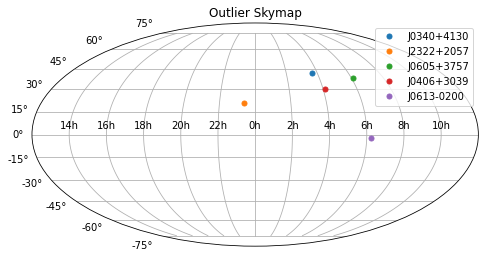

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
plt.title("Outlier Skymap")
plt.plot(Jra_radw1, Jdec_radw1, 'o', markersize=5, label = "J0340+4130")
plt.plot(Jra_radw2, Jdec_radw2, 'o', markersize=5, label = "J2322+2057")
plt.plot(Jra_radw3, Jdec_radw3, 'o', markersize=5, label = "J0605+3757")
plt.plot(Jra_radw4, Jdec_radw4, 'o', markersize=5, label = "J0406+3039")
plt.plot(Jra_radw5, Jdec_radw5, 'o', markersize=5, label = "J0613-0200")
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
plt.legend()
ax.grid(True)

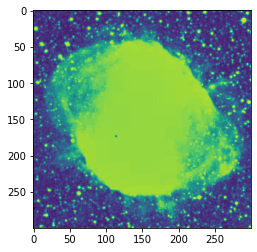

In [26]:
# Function to Get a Survey Image Provided the Object Position & Survey Name
# May need a downgrade of HTML5Lib: pip install --upgrade html5lib==1.0b8
def getSVImg(SC_ObjPos, SkyViewSurvey, pix):
    """
    Input: a SkyCoord Position Vector and a Survey Type that is Compatable with NASA SkyView
    Output: A Numpy Pixel Array and Header Array
    """
    img_survey, pix_survey, hdr_survey = None, None, None
    try:
        img_survey = SkyView.get_images(position=SC_ObjPos, survey=[SkyViewSurvey],
                                        coordinates="J2000", pixels=pix)
        if len(img_survey) > 0:
            pix_survey = img_survey[0][0].data
            hdr_survey = img_survey[0][0].header
    except (astroquery.exceptions.TimeoutError, urllib.error.HTTPError):
        pix_survey, hdr_survey = None, None
    return pix_survey, hdr_survey

if __name__ == "__main__":
    # Demo to Showcase that the SkyView image is working.
    Survey = 'DSS'
    ObjPos = 'Dumbbell Nebula'
    pix=300
    pixels, header = getSVImg(ObjPos, Survey, pix)
    plt.imshow(pixels)
    plt.show()
    

In [27]:
#J0340long = 62.6145455460622062521247599 #first crazy one
#J0340lat = 21.3325446194676085088365314

J0340long = ELONG[0]
J0340lat = ELAT[0]

#J0340longf = 62.6162150528992834143393598 
#J0340latf = 21.3351396400489844214914958 

J0340longf = ELONG[12]
J0340latf = ELAT[12]

josh = SkyCoord(J0340long*u.deg, J0340lat*u.deg, frame='barycentrictrueecliptic')
joshf = SkyCoord(J0340longf*u.deg, J0340latf*u.deg, frame='barycentrictrueecliptic')

from astropy.coordinates import ICRS
Jtimout1 = josh.transform_to('icrs') #RA and DEC 
Jtimout1f = joshf.transform_to('icrs') #RA and DEC 

#radians
Jra_radw1 = Jtimout1.ra.wrap_at(180 * u.deg).radian
Jdec_radw1 = Jtimout1.dec.radian

Jra_radw1f = Jtimout1f.ra.wrap_at(180 * u.deg).radian
Jdec_radw1f = Jtimout1f.dec.radian

#degrees
jboir_deg = Jtimout1.ra.degree
jboid_deg = Jtimout1.dec.degree

jboir_degf = Jtimout1f.ra.degree
jboid_degf = Jtimout1f.dec.degree

print(jboir_deg*u.deg)
print(jboid_deg*u.deg)

from astropy.coordinates import FK5
fk = josh.transform_to('fk5') #RA and DEC 
fkf = joshf.transform_to('fk5') #RA and DEC 

print(Jtimout1)
print(fk)
print(fkf)

92.55962543973656 deg
-21.0077863503551 deg
<SkyCoord (ICRS): (ra, dec) in deg
    (92.55962544, -21.00778635)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (92.55963093, -21.00779199)>
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (92.55963549, -21.00778474)>


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 92.5596  -21.0078  
CRPIX : 25.5  25.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00047222219999999997  0.00047222219999999997  
NAXIS : 50  50


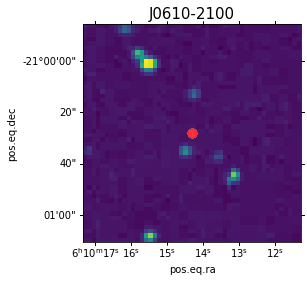

In [28]:
#circle showing the resolution of the telescope ;
if __name__ == "__main__":
    # Demo to Showcase that the SkyView image is working.
    Survey = 'DSS'
    #Survey = 'Fermi 5'
    pix=50
    pixels, header = getSVImg(josh, Survey, pix)
    
    WCS_helix = WCS(header)
    print(WCS_helix)
    
    fig = plt.figure()
    #ax = plt.subplot(projection=self.TPF.wcs)
    ax = plt.subplot(projection=WCS_helix)
    ax.get_transform(WCS(header))
    ax.imshow(pixels)
    
    ax.set_title(name,fontsize = 15)
    
    #ax.scatter(jboir_deg*u.deg, jboid_deg*u.deg, transform=ax.get_transform('fk5'),facecolors='none', edgecolors='r', s=10000)
    #ax.scatter(jboir_degf*u.deg, jboid_degf*u.deg, transform=ax.get_transform('fk5'),facecolors='none', edgecolors='lightblue', s=300)
    
    ax.scatter(jboir_deg*u.deg, jboid_deg*u.deg, transform=ax.get_transform('fk5'), color="white", s=80)
    ax.scatter(jboir_degf*u.deg, jboid_degf*u.deg, transform=ax.get_transform('fk5'), color="red", alpha=0.8, s=80)
    
    
    plt.show()

##### 